In [362]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [363]:
def load_images_from_subfolders(folder_path):
    images = []
    labels = []
    crop_types = os.listdir(folder_path)
    
    for crop_type in crop_types:
        crop_folder = os.path.join(folder_path, crop_type)
        if os.path.isdir(crop_folder):
            for filename in os.listdir(crop_folder):
                img_path = os.path.join(crop_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (256, 256)) 
                    images.append(img)
                    labels.append(crop_type)
                else:
                    print (img_path)
    print(f"Loaded {len(images)} images from {len(crop_types) - 1} crop types.") 
    return images, labels


def extract_features(images):
    features = []
    for img in images:
        #color histograms are sick, frequency vs intensity
        # parameter to chunk this 
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.append(hist)
    print(f"Extracted features for {len(features)} images.") 
    return np.array(features)

# Principle Component Analysis amongus
# Maximizes variance while minimizing features/axis 
# by construcing a covariance matrix of features
# then finding the eigenvalue, the variance of the new axises / principle component
# and the eigenvector which is the direction of the new axises
# top 50 components are now axises
# project og data onto axises
# Try consolidating data instead??
# Look into adjacency-relevant histogram specific methods
def apply_pca(features, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    print(f"Reduced features to {n_components} dimensions.") 
    return reduced_features


def cluster_images(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    print(f"Assigned {n_clusters} clusters.") 
    return labels


def plot_clusters(images, cluster_labels, n_clusters, max_images_per_cluster=5):
    fig, axes = plt.subplots(n_clusters, max_images_per_cluster, figsize=(20, n_clusters))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    if n_clusters == 1:
        axes = [axes]

    print (n_clusters)
    for cluster in range(n_clusters):
        cluster_images = np.where(cluster_labels == cluster)[0]
        print(f"Cluster {cluster} has {len(cluster_images)} images.") 
        for i in range(min(len(cluster_images), max_images_per_cluster)):
            img = images[cluster_images[i]]
            ax = axes[cluster, i]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        # Removes empty
        for j in range(i + 1, max_images_per_cluster):
            axes[cluster, j].axis('off')
    
    plt.show()
    


In [364]:
def plot_histogram(chunked_hist, chunk_size=2):

    hist_r = chunked_hist[0:20]  # Red channel
    hist_g = chunked_hist[20:40]  # Green channel
    hist_b = chunked_hist[40:80]  # Blue channel

    # Plot histograms for each channel
    plt.figure(figsize=(10, 4))
    
    plt.subplot(131)
    plt.plot(hist_r, color='r')
    plt.title('Red Channel')

    plt.subplot(132)
    plt.plot(hist_g, color='g')
    plt.title('Green Channel')

    plt.subplot(133)
    plt.plot(hist_b, color='b')
    plt.title('Blue Channel')
    
    plt.tight_layout()
    plt.show()

In [365]:
def chunk_histogram(hist, chunk_size=2):
    # Reshape histogram into 8x8x8
    reshaped_hist = hist.reshape(20, 20, 20)
    
    # Initialize chunked histogram
    chunked_hist = np.zeros((int(20/chunk_size), int(20/chunk_size), int(20/chunk_size)))
    
    # Chunk by averaging adjacent bins in 2x2x2 blocks
    for i in range(0, 20, chunk_size):
        for j in range(0, 20, chunk_size):
            for k in range(0, 20, chunk_size):
                chunk = reshaped_hist[i:i+chunk_size, j:j+chunk_size, k:k+chunk_size]
                chunked_hist[i//chunk_size, j//chunk_size, k//chunk_size] = np.mean(chunk)
    
    return chunked_hist.flatten() # Flatten back to a 1D vector

# Feature extraction with bin chunking
def extract_features(images, chunk_size=2, isShow=False):
    features = []
    i = 0
    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, [20, 20, 20], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()  # Normalize and flatten
        # Chunk the histogram to reduce the number of bins
        chunked_hist = chunk_histogram(hist, chunk_size=chunk_size)
        #if i % 70 == 0:
        if isShow:
            plot_histogram(chunked_hist)
        features.append(chunked_hist)
        i += 1
    print(f"Extracted features for {len(features)} images.") 
    return np.array(features)

In [366]:
# folder_path = '/Users/johnxu/Downloads/Agricultural-crops' 
# images, true_labels = load_images_from_subfolders(folder_path)
# unique_crop_types = list(set(true_labels))
# n_clusters = len(unique_crop_types) 

In [367]:
folder_path = '/Users/johnxu/Documents/VSCode/Drone/images'
images, true_labels = load_images_from_subfolders(folder_path)
unique_crop_types = list(set(true_labels))
n_clusters = len(unique_crop_types) 

Loaded 96 images from 2 crop types.


In [368]:

features = extract_features(images, chunk_size=2)


Extracted features for 96 images.


In [369]:
scaler = StandardScaler() #mean 0 std 1
scaled_features = scaler.fit_transform(features)

reduced_features = apply_pca(scaled_features, n_components=20)

Reduced features to 20 dimensions.


In [370]:
cluster_labels = cluster_images(reduced_features, n_clusters)

Assigned 2 clusters.


2
Cluster 0 has 94 images.
Cluster 1 has 2 images.


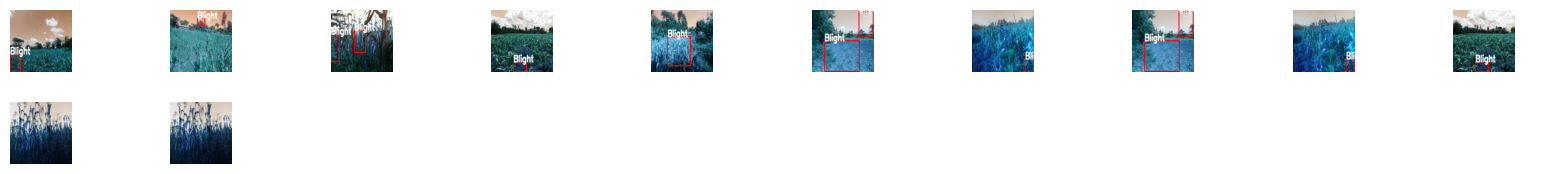

In [371]:
plot_clusters(images, cluster_labels, n_clusters, max_images_per_cluster=10)

In [372]:
i = 0
collective = []
for label in cluster_labels:
    if (label == 17):
        collective.append(images[i])
    i += 1


In [373]:
features = extract_features(collective, chunk_size=2, isShow=True)

Extracted features for 0 images.


In [374]:
#export GOOGLE_APPLICATION_CREDENTIALS="drone-app-440214-2b7e3b8228ab.json";

In [375]:
# import os
# from google.cloud import storage

# def upload_folder_to_gcs(folder_path, bucket_name, gcs_folder=""):
#     client = storage.Client()
#     bucket = client.bucket(bucket_name)
    
#     # Loop through all files in the folder
#     for root, _, files in os.walk(folder_path):
#         for filename in files:
#             local_path = os.path.join(root, filename)
            
#             # Define the destination path in GCS
#             relative_path = os.path.relpath(local_path, folder_path)
#             blob_path = os.path.join(gcs_folder, relative_path).replace("\\", "/")  # Use forward slashes for GCS paths
            
#             # Create a blob and upload the file
#             blob = bucket.blob(blob_path)
#             blob.upload_from_filename(local_path)
#             print(f"Uploaded {local_path} to gs://{bucket_name}/{blob_path}")

# folder_path = "/Users/johnxu/Downloads/Agricultural-crops"
# bucket_name = "crops"
# gcs_folder = "rawImages"

# upload_folder_to_gcs(folder_path, bucket_name, gcs_folder)


In [376]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

def load_images_from_subfolders(folder_path):
    images = []
    labels = []
    crop_types = os.listdir(folder_path)
    
    for crop_type in crop_types:
        crop_folder = os.path.join(folder_path, crop_type)
        if os.path.isdir(crop_folder):
            for filename in os.listdir(crop_folder):
                img_path = os.path.join(crop_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (256, 256)) 
                    images.append(img)
                    labels.append(crop_type)
                else:
                    print(f"Could not load image: {img_path}")
    print(f"Loaded {len(images)} images from {len(crop_types) - 1} crop types.") 
    return images, labels

def extract_features(images, chunk_size=2):
    features = []
    for img in images:
        # Iterate through color channels with variable chunk size
        hist = cv2.calcHist([img], [0, 1, 2], None, [chunk_size, chunk_size, chunk_size], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.append(hist)
    return np.array(features)

def tune_parameters(folder_path):
    # Load images
    images, true_labels = load_images_from_subfolders(folder_path)
    unique_crop_types = list(set(true_labels))
    n_clusters = len(unique_crop_types)


    chunk_sizes = [2, 4, 8, 16]  
    n_components_range = [20, 35, 40, 45, 50]
    
    # Storage for results
    results = []

    for chunk_size in chunk_sizes:
        for n_components in n_components_range:
            try:
                
                features = extract_features(images, chunk_size=chunk_size)
                
        
                scaler = StandardScaler()
                scaled_features = scaler.fit_transform(features)
                
                pca = PCA(n_components=n_components)
                reduced_features = pca.fit_transform(scaled_features)
                
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                cluster_labels = kmeans.fit_predict(reduced_features)
                
                # Evaluation metrics
                silhouette = silhouette_score(reduced_features, cluster_labels)
                

                try:
                    rand_index = adjusted_rand_score(true_labels, cluster_labels)
                except ValueError:
                    rand_index = None
                
                # Store results
                results.append({
                    'chunk_size': chunk_size,
                    'n_components': n_components,
                    'silhouette_score': silhouette,
                    'rand_index': rand_index
                })
                
                print(f"Chunk Size: {chunk_size}, PCA Components: {n_components}")
                print(f"Silhouette Score: {silhouette}")
                if rand_index is not None:
                    print(f"Adjusted Rand Index: {rand_index}")
                print("---")
                
            except Exception as e:
                print(f"Error with chunk_size {chunk_size}, n_components {n_components}: {e}")

    # Find best parameters
    best_result = max(results, key=lambda x: x['silhouette_score'])
    print("\nBEST PARAMETERS:")
    print(f"Chunk Size: {best_result['chunk_size']}")
    print(f"PCA Components: {best_result['n_components']}")
    print(f"Silhouette Score: {best_result['silhouette_score']}")
    
    return results

# Run parameter tuning
folder_path = '/Users/johnxu/Documents/VSCode/Drone/images'
results = tune_parameters(folder_path)

Loaded 96 images from 2 crop types.
Error with chunk_size 2, n_components 20: n_components=20 must be between 0 and min(n_samples, n_features)=8 with svd_solver='covariance_eigh'
Error with chunk_size 2, n_components 35: n_components=35 must be between 0 and min(n_samples, n_features)=8 with svd_solver='covariance_eigh'
Error with chunk_size 2, n_components 40: n_components=40 must be between 0 and min(n_samples, n_features)=8 with svd_solver='covariance_eigh'
Error with chunk_size 2, n_components 45: n_components=45 must be between 0 and min(n_samples, n_features)=8 with svd_solver='covariance_eigh'
Error with chunk_size 2, n_components 50: n_components=50 must be between 0 and min(n_samples, n_features)=8 with svd_solver='covariance_eigh'
Chunk Size: 4, PCA Components: 20
Silhouette Score: 0.3291438817977905
Adjusted Rand Index: 0.21664696944116157
---
Chunk Size: 4, PCA Components: 35
Silhouette Score: 0.32125434279441833
Adjusted Rand Index: 0.21664696944116157
---
Chunk Size: 4, P

    chunk_size  n_components  silhouette_score  rand_index
0            4            20          0.329144    0.216647
1            4            35          0.321254    0.216647
2            4            40          0.321234    0.216647
3            4            45          0.321234    0.216647
4            4            50          0.321234    0.216647
5            8            20          0.323280   -0.054528
6            8            35          0.291769   -0.054528
7            8            40          0.289142   -0.054528
8            8            45          0.288064   -0.054528
9            8            50          0.287918   -0.054528
10          16            20          0.393475   -0.030492
11          16            35          0.346144   -0.030492
12          16            40          0.340959   -0.030492
13          16            45          0.338273   -0.030492
14          16            50          0.338023   -0.030492


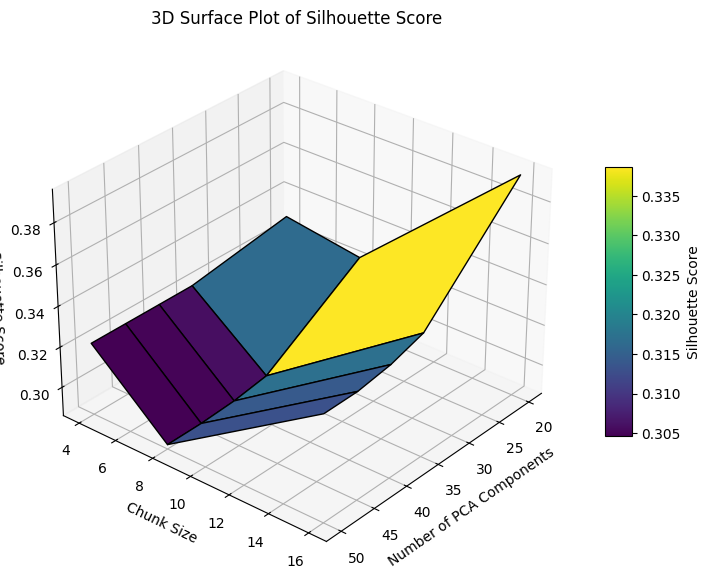

In [387]:

chunk_sizes = [2, 4, 8, 16]
n_components_range = [20, 35, 40, 45, 50]



df_dummy = pd.DataFrame(results)

print (df_dummy)

pivot_table_dummy = df_dummy.pivot(index='chunk_size', columns='n_components', values='silhouette_score')

X_dummy, Y_dummy = np.meshgrid(pivot_table_dummy.columns, pivot_table_dummy.index)
Z_dummy = pivot_table_dummy.values


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=30, azim=40)

surf_dummy = ax.plot_surface(X_dummy, Y_dummy, Z_dummy, cmap='viridis', edgecolor='k', alpha=1)


ax.set_title('3D Surface Plot of Silhouette Score')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Chunk Size')
ax.set_zlabel('Silhouette Score')

fig.colorbar(surf_dummy, ax=ax, shrink=0.5, aspect=10, label='Silhouette Score')

plt.show()
